# Dataset setup for Faster RCNN

Dataset setup is critical in order to understand how does an algorithm work, and I found most of the tutorials in the Internet is lacking in this area. In this blog post, I would like to share how the dataset was setup for training a faster RCNN network. For simplicity, I'll only use PASCAL VOC 2007 as an example. Please feel free to check out how the rest of datasets are created and transformed

## How was the dataset being consumed?

We first start with analysing the training and validation script. I have taken the reference from the implementation by [jwyang](https://github.com/jwyang/faster-rcnn.pytorch), but I found it is similar in the original implentation by [rbgirshick](https://github.com/rbgirshick/py-faster-rcnn)

Reference to `trainval_net.py` for jwyang's implementation  
Reference to `train_net.py` for rbgirshick's implementation

### 1. Training script [`trainval_net.py`](https://github.com/jwyang/faster-rcnn.pytorch/blob/master/trainval_net.py)

**In `./trainval_net.py`**
```python
if __name__ == '__main__':
    
    # Some other stuff above
    
    imdb, roidb, ratio_list, ratio_index = combined_roidb(args.imdb_name) <-----------
    train_size = len(roidb)

    print('{:d} roidb entries'.format(len(roidb)))
    
    # Some other stuff below
```
The data loading starts from the `combined_roidb` function, which sits under [`./lib/roi_data_layer/roidb.py`](https://github.com/jwyang/faster-rcnn.pytorch/blob/master/lib/roi_data_layer/roidb.py)

### 2. `combined_roidb()` and its functions
`combined_roidb()` does several things:  

1. Get all the roidbs by `roidbs = [get_roidb(s) for s in imdb_names.split('+')]`, where
    - Get the image library by `imdb = get_imdb(imdb_name)`
    - Get the RoI from image library by `roidb = get_training_roidb(imdb)`
2. Combine a list of roidbs by using `extend()`
3. Filter the roidb if in training mode
4. Make sure the RoIs are within ratio of 0.5 < x < 2 by `rank_roidb_ratio(roidb)`
5. return imdb, roidb, ratio_list, ratio_index

**In [`/lib/roi_data_layer/roidb.py`](https://github.com/jwyang/faster-rcnn.pytorch/blob/master/lib/roi_data_layer/roidb.py)**
```python
def combined_roidb(imdb_names, training=True):
    """
    Combine multiple roidbs
    """
    # I have rearranged the order for better understanding
    roidbs = [get_roidb(s) for s in imdb_names.split('+')]   # run get_roidb(imdb_name)
      roidb = roidbs[0]

      if len(roidbs) > 1:
        for r in roidbs[1:]:
          roidb.extend(r)
        tmp = get_imdb(imdb_names.split('+')[1])
        imdb = datasets.imdb.imdb(imdb_names, tmp.classes)
      else:
        imdb = get_imdb(imdb_names)

      if training:
        roidb = filter_roidb(roidb)

      ratio_list, ratio_index = rank_roidb_ratio(roidb)

    # Some helper functions
      def get_training_roidb(imdb):
        """Returns a roidb (Region of Interest database) for use in training."""
        if cfg.TRAIN.USE_FLIPPED:
          print('Appending horizontally-flipped training examples...')
          imdb.append_flipped_images()
          print('done')

        print('Preparing training data...')

        prepare_roidb(imdb)
        #ratio_index = rank_roidb_ratio(imdb)
        print('done')

        return imdb.roidb

      def get_roidb(imdb_name):
        imdb = get_imdb(imdb_name)
        print('Loaded dataset `{:s}` for training'.format(imdb.name))
        imdb.set_proposal_method(cfg.TRAIN.PROPOSAL_METHOD)
        print('Set proposal method: {:s}'.format(cfg.TRAIN.PROPOSAL_METHOD))
        roidb = get_training_roidb(imdb)
        return roidb

  return imdb, roidb, ratio_list, ratio_index
```

### 3. What is imdb (Image database I guess)? Deep dive into `get_imdb(imdb_name)`

**In `get_imdb(imdb_name)` of [`faster-rcnn.pytorch/lib/datasets/factory.py`](https://github.com/jwyang/faster-rcnn.pytorch/blob/master/lib/datasets/factory.py)**

```python
def get_imdb(name):
  """Get an imdb (image database) by name."""
  if name not in __sets:
    raise KeyError('Unknown dataset: {}'.format(name))
  return __sets[name]()
```

From the script, we know that `get_imdb(name)` is a factory function that creates the dataset. Since we are using the PASCAL_VOC 2007 dataset, the result is illustrated as follow

#### Excerpt of [`./lib/datasets/factory.py`](https://github.com/jwyang/faster-rcnn.pytorch/blob/master/lib/datasets/factory.py)**

In [3]:
# Empty sets
__sets = {}

In [4]:
# Set up voc_<year>_<split>
for year in ['2007', '2012']:
  for split in ['train', 'val', 'trainval', 'test']:
    name = 'voc_{}_{}'.format(year, split)
    __sets[name] = (lambda split=split, year=year: pascal_voc(split, year))
    
print(__sets)

{'voc_2007_train': <function <lambda> at 0x105da5488>, 'voc_2007_val': <function <lambda> at 0x105da5400>, 'voc_2007_trainval': <function <lambda> at 0x105da5378>, 'voc_2007_test': <function <lambda> at 0x105da52f0>, 'voc_2012_train': <function <lambda> at 0x105da5268>, 'voc_2012_val': <function <lambda> at 0x105da51e0>, 'voc_2012_trainval': <function <lambda> at 0x105da5158>, 'voc_2012_test': <function <lambda> at 0x105da50d0>}


In [5]:
def get_imdb(name):
  """Get an imdb (image database) by name."""
  if name not in __sets:
    raise KeyError('Unknown dataset: {}'.format(name))
  return __sets[name]()

# > get_imdb("voc_2007_train") = Run pascal_voc(train)

The run of `pascal_voc` leads to a run in [`./lib/datasets/pascal_voc.py`](https://github.com/jwyang/faster-rcnn.pytorch/blob/master/lib/datasets/pascal_voc.py)

**In [`./lib/datasets/pascal_voc.py`](https://github.com/jwyang/faster-rcnn.pytorch/blob/master/lib/datasets/pascal_voc.py)**
```python
class pascal_voc(imdb):
    # Subclass of imdb
    def __init__(self, image_set, year, devkit_path=None):
        imdb.__init__(self, 'voc_' + year + '_' + image_set)
        self._year = year
        self._image_set = image_set
        self._devkit_path = self._get_default_path() if devkit_path is None \
            else devkit_path
        self._data_path = os.path.join(self._devkit_path, 'VOC' + self._year)
        self._classes = ('__background__',  # always index 0
                         'aeroplane', 'bicycle', 'bird', 'boat',
                         'bottle', 'bus', 'car', 'cat', 'chair',
                         'cow', 'diningtable', 'dog', 'horse',
                         'motorbike', 'person', 'pottedplant',
                         'sheep', 'sofa', 'train', 'tvmonitor')
        self._class_to_ind = dict(zip(self.classes, xrange(self.num_classes)))
        self._image_ext = '.jpg'
        self._image_index = self._load_image_set_index()
        # Default to roidb handler
        # self._roidb_handler = self.selective_search_roidb
        self._roidb_handler = self.gt_roidb
        self._salt = str(uuid.uuid4())
        self._comp_id = 'comp4'

        # PASCAL specific config options
        self.config = {'cleanup': True,
                       'use_salt': True,
                       'use_diff': False,
                       'matlab_eval': False,
                       'rpn_file': None,
                       'min_size': 2}

        assert os.path.exists(self._devkit_path), \
            'VOCdevkit path does not exist: {}'.format(self._devkit_path)
        assert os.path.exists(self._data_path), \
            'Path does not exist: {}'.format(self._data_path)
```

**WOW!** Now we know what a imdb is. It is a dataset with predefined format by its superclass `imdb`, which stores in [`./lib/datasets/imdb.py`](https://github.com/jwyang/faster-rcnn.pytorch/blob/master/lib/datasets/imdb.py). 

```python
class imdb(object):
  """Image database."""

  def __init__(self, name, classes=None):
    self._name = name
    self._num_classes = 0
    if not classes:
      self._classes = []
    else:
      self._classes = classes
    self._image_index = []
    self._obj_proposer = 'gt'
    self._roidb = None
    self._roidb_handler = self.default_roidb
    # Use this dict for storing dataset specific config options
    self.config = {}
```

Clearly, the imdb class defines the structure of each dataset, including
- name
- num_classes
- classes
- image_index
- object proposer
- roidb
- roidb handler (?)
- config

So, now we know the imdb of `roidb = get_training_roidb(imdb)` is actually a predefined dataset. Now, we can deep dive into `get_training_roidb(imdb)`

## 4. `get_training_roidb(imdb)`

Running `get_training_roidb(imdb_name)` actually runs the `prepare_roidb(imdb)` function.  


The purpose of `prepare_roidb(imdb)` is to enrich the dataset with the following quantities. Here's the docstring of `prepare_roidb(imdb)`
>   Enrich the imdb's roidb by adding some derived quantities that
    are useful for training.  
    This function precomputes the **maximum
    overlap**, **taken over ground-truth boxes, between each ROI and
    each ground-truth box**. **The class with maximum overlap is also
    recorded.**

- `roidb[i]['image']`: Image path
- `roidb[i]['width']`: Width of an image
- `roidb[i]['height']`: Height of an image
- Convert the `roidb[i]['overlap']` to array()
- `max_overlaps`
- `max_classes`

### 4.1. `prepare_roidb(imdb)`

**In [`/lib/roi_data_layer/roidb.py`](https://github.com/jwyang/faster-rcnn.pytorch/blob/master/lib/roi_data_layer/roidb.py)**
```python
def prepare_roidb(imdb):
  """Enrich the imdb's roidb by adding some derived quantities that
  are useful for training. This function precomputes the maximum
  overlap, taken over ground-truth boxes, between each ROI and
  each ground-truth box. The class with maximum overlap is also
  recorded.
  """

  roidb = imdb.roidb
    
  # Something else
```
**The first line of code takes `imdb.roidb`.**  
Thus, before looking into each enrichment done by the function, let's look into what `imdb.roidb` is.

**In [`./lib/datasets/imdb.py`](https://github.com/jwyang/faster-rcnn.pytorch/blob/master/lib/datasets/imdb.py)**
```python
@property
  def roidb(self):
    # A roidb is a list of dictionaries, each with the following keys:
    #   boxes
    #   gt_overlaps
    #   gt_classes
    #   flipped
    if self._roidb is not None:
      return self._roidb
    self._roidb = self.roidb_handler()
    return self._roidb
```

Now, we know that roidb is a class property that return a list of dictionaries of **`[{boxes, gt_overlaps, gt_classes, flipped, image, width, height, max_overlaps, max_classes}]`** of each of the image. These information is from its respective XML file.

From `pascal_voc.py`, the `roidb_handler()`, we then know that the actual implementation for a PASCAL VOC dataset is actually the following

**In [`./lib/datasets/pascal_voc.py`](https://github.com/jwyang/faster-rcnn.pytorch/blob/master/lib/datasets/pascal_voc.py)**
```python
# In __init__, it says the roidb_handler is actually the gt_roidb()
self._roidb_handler = self.gt_roidb

# Here we have the self.gt_doidb()
def gt_roidb(self):
        """
        Return the database of ground-truth regions of interest.
        This function loads/saves from/to a cache file to speed up future calls.
        """
        # If we have a cache file, then load from cache
        cache_file = os.path.join(self.cache_path, self.name + '_gt_roidb.pkl')
        if os.path.exists(cache_file):
            with open(cache_file, 'rb') as fid:
                roidb = pickle.load(fid)
            print('{} gt roidb loaded from {}'.format(self.name, cache_file))
            return roidb

        # If not, we generate from the pascal annotation file, and write to a cache file
        
        # Only this line is important
        gt_roidb = [self._load_pascal_annotation(index)
                    for index in self.image_index]
        with open(cache_file, 'wb') as fid:
            pickle.dump(gt_roidb, fid, pickle.HIGHEST_PROTOCOL)
        print('wrote gt roidb to {}'.format(cache_file))

        return gt_roidb
```

Obviously, the dataset is loaded from pascal dataset by **`_load_pascal_annotation(index)`**.  
Here's a demonstration of the function. For simplicity, I have changed a bit for the experiment

In [6]:
import xml.etree.ElementTree as ET
import scipy.sparse
import numpy as np

from pathlib import Path

In [40]:
num_objs = 10      # There are 10 objects in the xml file
num_classes = 21   # 20 classes + 1 class of background

# Get an example from VOC2007
annotation_xml = str(Path("../data/VOC2007/Annotations/000050.xml"))
image_path = str(Path("../data/VOC2007/JPEGImages/000050.jpg"))

In [8]:
# Copy from pascal_voc.py
_classes = ('__background__',  # always index 0
                 'aeroplane', 'bicycle', 'bird', 'boat',
                 'bottle', 'bus', 'car', 'cat', 'chair',
                 'cow', 'diningtable', 'dog', 'horse',
                 'motorbike', 'person', 'pottedplant',
                 'sheep', 'sofa', 'train', 'tvmonitor')
_class_to_ind = dict(list(zip(_classes, list(range(num_classes)))))

print("_classes ->", _classes, end="\n\n")
print("_class_to_ind ->", _class_to_ind)

_classes -> ('__background__', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor')

_class_to_ind -> {'__background__': 0, 'aeroplane': 1, 'bicycle': 2, 'bird': 3, 'boat': 4, 'bottle': 5, 'bus': 6, 'car': 7, 'cat': 8, 'chair': 9, 'cow': 10, 'diningtable': 11, 'dog': 12, 'horse': 13, 'motorbike': 14, 'person': 15, 'pottedplant': 16, 'sheep': 17, 'sofa': 18, 'train': 19, 'tvmonitor': 20}


In [9]:
def _load_pascal_annotation(annotation_xml):
    """
    Load image and bounding boxes info from XML file in the PASCAL VOC
    format.
    """
    filename = annotation_xml
    tree = ET.parse(filename)
    objs = tree.findall('object')
    num_objs = len(objs)

    # Initialization
    boxes = np.zeros((num_objs, 4), dtype=np.uint16) # <----------
    gt_classes = np.zeros((num_objs), dtype=np.int32) # <----------
    overlaps = np.zeros((num_objs, num_classes), dtype=np.float32)   # <----------
    # "Seg" area for pascal is just the box area
    seg_areas = np.zeros((num_objs), dtype=np.float32)   # <------------

    # Load object bounding boxes into a data frame.
    for ix, obj in enumerate(objs):
      bbox = obj.find('bndbox')
      # Make pixel indexes 0-based
      x1 = float(bbox.find('xmin').text) - 1
      y1 = float(bbox.find('ymin').text) - 1
      x2 = float(bbox.find('xmax').text) - 1
      y2 = float(bbox.find('ymax').text) - 1
      cls = _class_to_ind[obj.find('name').text.lower().strip()]
      boxes[ix, :] = [x1, y1, x2, y2]
      gt_classes[ix] = cls
      overlaps[ix, cls] = 1.0
      seg_areas[ix] = (x2 - x1 + 1) * (y2 - y1 + 1)

    overlaps = scipy.sparse.csr_matrix(overlaps)

    return {'boxes': boxes,
            'gt_classes': gt_classes,
            'gt_overlaps': overlaps,
            'flipped': False,
            'seg_areas': seg_areas}

The initialization of boxes, gt_classes, overlaps and seg_areas are like this

In [10]:
boxes = np.zeros((num_objs, 4), dtype=np.uint16)
gt_classes = np.zeros((num_objs), dtype=np.int32)
overlaps = np.zeros((num_objs, num_classes), dtype=np.float32)
# "Seg" area for pascal is just the box area
seg_areas = np.zeros((num_objs), dtype=np.float32)

print("boxes ->", boxes)
print("gt_classes ->", gt_classes)
print("overlaps ->", overlaps)
print("seg_areas ->", seg_areas)

boxes -> [[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]
gt_classes -> [0 0 0 0 0 0 0 0 0 0]
overlaps -> [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
seg_areas -> [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Thus, if we run the whole `_load_pascal_annotation(image_xml)`, we will have the following result. This result will be stored to `pascal_voc.roidb`

In [11]:
roidb = [_load_pascal_annotation(annotation_xml) for i in range(10)]  # This is actually pascal_voc.roidb

In [14]:
# Each roidb has 5 elements
len(roidb[0])

5

In [15]:
roidb[0]

{'boxes': array([[404, 152, 492, 254],
        [274, 128, 311, 169],
        [359, 191, 380, 264],
        [398, 180, 421, 234],
        [269, 179, 290, 246],
        [293, 175, 311, 240],
        [ 67,  95, 292, 374],
        [  0,  70,  86, 331],
        [184,  67, 258, 196],
        [285,  63, 405, 237]], dtype=uint16),
 'flipped': False,
 'gt_classes': array([ 9,  9,  5,  5,  5,  5, 15, 15, 15, 15], dtype=int32),
 'gt_overlaps': <10x21 sparse matrix of type '<class 'numpy.float32'>'
 	with 10 stored elements in Compressed Sparse Row format>,
 'seg_areas': array([ 9167.,  1596.,  1628.,  1320.,  1496.,  1254., 63280., 22794.,
         9750., 21175.], dtype=float32)}

Note that the format of bounding box is `<left> <top> <right> <bottom>`

#### Preview the image

In [36]:
# Preview the image
import sys

sys.path.append("/Users/admin/Desktop/github/findme-ai/")

In [49]:
from utils.vision_utils import draw_im, open_image

In [46]:
annotation_50 = tuple(zip(roidb[0]['boxes'], roidb[0]['gt_classes']))

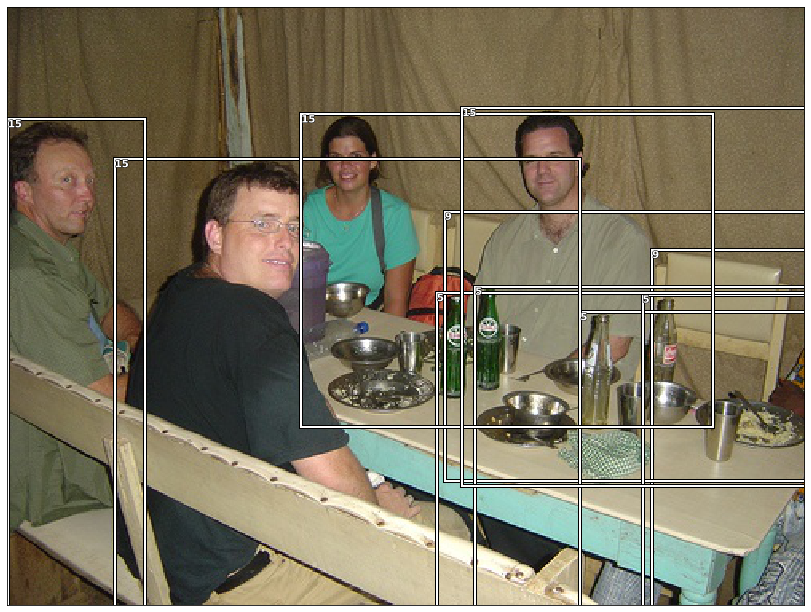

In [50]:
%matplotlib inline

draw_im(open_image(image_path), annotation_50)

##### Just a note that this function does not return any variables. Since python functions are pass by reference, which means the origin roidb has been updated with these quantities

In [11]:
example = [{"key_a": 0, "key_b": 1}]

In [12]:
def add_key_to_example(example):
    example['key_c'] = 2

In [13]:
add_key_to_example(example[0])

In [14]:
print(example)

[{'key_a': 0, 'key_b': 1, 'key_c': 2}]


You may be wondering why we need overlaps? I'm not sure too, but from the training script, it is found for using filtering out the boxes that are not useful for training.

### 3. `filter_roidb()`
The purpose of filter roidb is to remove the entries that have no use for training. We only need the valid images that are
1. At least one foregound RoI, OR
2. At least one background RoI

**In [`/lib/roi_data_layer/roidb.py`](https://github.com/jwyang/faster-rcnn.pytorch/blob/master/lib/roi_data_layer/roidb.py)**
```python
def filter_roidb(roidb):
    """Remove roidb entries that have no usable RoIs."""

    def is_valid(entry):
        # Valid images have:
        #   (1) At least one foreground RoI OR
        #   (2) At least one background RoI
        overlaps = entry['max_overlaps']
        # find boxes with sufficient overlap
        fg_inds = np.where(overlaps >= cfg.TRAIN.FG_THRESH)[0]
        # Select background RoIs as those within [BG_THRESH_LO, BG_THRESH_HI)
        bg_inds = np.where((overlaps < cfg.TRAIN.BG_THRESH_HI) &
                           (overlaps >= cfg.TRAIN.BG_THRESH_LO))[0]
        # image is only valid if such boxes exist
        valid = len(fg_inds) > 0 or len(bg_inds) > 0
        return valid

    num = len(roidb)  # roidb is a list of dictionaries
    filtered_roidb = [entry for entry in roidb if is_valid(entry)]
    num_after = len(filtered_roidb)
    print 'Filtered {} roidb entries: {} -> {}'.format(num - num_after,
                                                       num, num_after)
    return filtered_roidb
```

After filtering out the annotations that are not useful, we will have a list of dictionaries for the respective annotation. 

Hence, we will rank the roidb base on the width and height.  
Wondering why do we need to do that? **Because we need to ensure the image ratio is with 0.5 to 2, otherwise we need to crop it.**

**In [`/lib/roi_data_layer/roidb.py`](https://github.com/jwyang/faster-rcnn.pytorch/blob/master/lib/roi_data_layer/roidb.py)**
```python
def rank_roidb_ratio(roidb):
    # rank roidb based on the ratio between width and height.
    ratio_large = 2 # largest ratio to preserve.
    ratio_small = 0.5 # smallest ratio to preserve.    
    
    ratio_list = []
    for i in range(len(roidb)):
      # Here width and height are referring to the image ratio
      width = roidb[i]['width']
      height = roidb[i]['height']
      ratio = width / float(height)

      if ratio > ratio_large:
        roidb[i]['need_crop'] = 1
        ratio = ratio_large
      elif ratio < ratio_small:
        roidb[i]['need_crop'] = 1
        ratio = ratio_small        
      else:
        roidb[i]['need_crop'] = 0

      ratio_list.append(ratio)

    ratio_list = np.array(ratio_list)
    ratio_index = np.argsort(ratio_list)
    # Return ratio from small to large, and its respective index
    return ratio_list[ratio_index], ratio_index
```

In [15]:
ratio_list_dummy = np.array([1.33, 2, 3, 5, 1.5, 1.7])
ratio_index_dummy = np.argsort(ratio_list_dummy)

print("ratio_list_dummy ->", ratio_list_dummy)
print("ratio_index_dummy ->", ratio_index_dummy)
print("ratio_list_dummy[ratio_index_dummy] ->", ratio_list_dummy[ratio_index_dummy])

ratio_list_dummy -> [1.33 2.   3.   5.   1.5  1.7 ]
ratio_index_dummy -> [0 4 5 1 2 3]
ratio_list_dummy[ratio_index_dummy] -> [1.33 1.5  1.7  2.   3.   5.  ]


In [17]:
ratio_index_dummy[1]

4

Finally, the `combined_roidb(imdb_names, training=True)` returns a tuple of `imdb, roidb, ratio_list, ratio_index`

To recap, the whole `combined_roidb(imdb_names)` looks like this. For full implementation, please refer to **[Here](https://github.com/jwyang/faster-rcnn.pytorch/blob/master/lib/roi_data_layer/roidb.py)**

**In [`/lib/roi_data_layer/roidb.py`](https://github.com/jwyang/faster-rcnn.pytorch/blob/master/lib/roi_data_layer/roidb.py)**
```python
def combined_roidb(imdb_names, training=True):
  """
  Combine multiple roidbs
  """

  def get_training_roidb(imdb):
    """Returns a roidb (Region of Interest database) for use in training."""
    if cfg.TRAIN.USE_FLIPPED:
      print('Appending horizontally-flipped training examples...')
      imdb.append_flipped_images()
      print('done')

    print('Preparing training data...')

    prepare_roidb(imdb)
    #ratio_index = rank_roidb_ratio(imdb)
    print('done')

    return imdb.roidb
  
  def get_roidb(imdb_name):
    imdb = get_imdb(imdb_name)
    print('Loaded dataset `{:s}` for training'.format(imdb.name))
    imdb.set_proposal_method(cfg.TRAIN.PROPOSAL_METHOD)
    print('Set proposal method: {:s}'.format(cfg.TRAIN.PROPOSAL_METHOD))
    roidb = get_training_roidb(imdb)
    return roidb

  roidbs = [get_roidb(s) for s in imdb_names.split('+')]
  roidb = roidbs[0]

  if len(roidbs) > 1:
    for r in roidbs[1:]:
      roidb.extend(r)
    tmp = get_imdb(imdb_names.split('+')[1])
    imdb = datasets.imdb.imdb(imdb_names, tmp.classes)
  else:
    imdb = get_imdb(imdb_names)

  if training:
    roidb = filter_roidb(roidb)

  ratio_list, ratio_index = rank_roidb_ratio(roidb)

  return imdb, roidb, ratio_list, ratio_index
```

## The roidb data loader
After the data is reshaped by `prepare_roidb()`, the `roidb`, `ratio_list`, `ratio_index` are loaded into a dataloader.  
The role of dataloader is to fetch the data into batch. Here is the implementation

**In `./trainval_net.py` (line 208-212)**, we can see the data is loaded by 
```python
dataset = roibatchLoader(roidb, ratio_list, ratio_index, args.batch_size, \
                         imdb.num_classes, training=True)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=args.batch_size,
                        sampler=sampler_batch, num_workers=args.num_workers)
```

In order to support multiple image training, we have to fix the ratio for each batch. The implementation below use the left_idx and right_idx to unify the image ratio. The reason why this is make sense because the author has ranked the image ratio accordingly. 

From the function `rank_roidb_ratio(roidb)` (mentioned above), the ratio_list and ratio_index has been ranked in ascending order. Recall that the image ratio is defined as `width/height`. Small image ratio means the image has height > width, and vice versa.

Recall the `ratio_list` and `ratio_index` should look like this:
```
# Original
ratio_list_dummy -> [1.33 2.   3.   5.   1.5  1.7 ]

# Returned by rank_roidb_ratio(roidb)
ratio_index_dummy -> [0 4 5 1 2 3]
ratio_list_dummy[ratio_index_dummy] -> [1.33 1.5  1.7  2.   3.   5.  ]
```

**In [`./lib/roi_data_layer/roibatchLoader.py`](https://github.com/jwyang/faster-rcnn.pytorch/blob/master/lib/roi_data_layer/roibatchLoader.py)**
```python
class roibatchLoader(data.Dataset):
  def __init__(self, roidb, ratio_list, ratio_index, batch_size, num_classes, training=True, normalize=None):
    self._roidb = roidb
    self._num_classes = num_classes
    # we make the height of image consistent to trim_height, trim_width
    self.trim_height = cfg.TRAIN.TRIM_HEIGHT
    self.trim_width = cfg.TRAIN.TRIM_WIDTH
    self.max_num_box = cfg.MAX_NUM_GT_BOXES
    self.training = training
    self.normalize = normalize
    self.ratio_list = ratio_list
    self.ratio_index = ratio_index
    self.batch_size = batch_size
    self.data_size = len(self.ratio_list)   # <------ Should be same as len(roidb)

    # given the ratio_list, we want to make the ratio same for each batch.
    self.ratio_list_batch = torch.Tensor(self.data_size).zero_()
    num_batch = int(np.ceil(len(ratio_index) / batch_size))
    
    for i in range(num_batch):
        left_idx = i*batch_size
        right_idx = min((i+1)*batch_size-1, self.data_size-1)

        # Recall that ratio_list is ranked in ascending order
        # If the maximum ratio of the list is still < 1, then we take the ratio of the left most
        # Vice versa.
        if ratio_list[right_idx] < 1:
            # for ratio < 1, we preserve the leftmost in each batch.
            target_ratio = ratio_list[left_idx]
            # or we can just do
            # target_ratio = 0.5
        elif ratio_list[left_idx] > 1:
            # for ratio > 1, we preserve the rightmost in each batch.
            target_ratio = ratio_list[right_idx]
            # target_ratio = 2
        else:
            # for ratio cross 1, we make it to be 1.
            target_ratio = 1

        self.ratio_list_batch[left_idx:(right_idx+1)] = target_ratio
```

#### Image transformation, rgb channel switch, resizing, etc.

Once the dataloader is initiated, we have to define how to fetch the data. The function is quite long, so let's break it down.

The function takes an index (which is the normal approach for torch dataset), to support the indexing to get the ith sample. In the training mode, we fetch the data according to their image ratio in an ascending order. Hence, we map it back to roidb to fetch the correct image.

**In [`./lib/roi_data_layer/roibatchLoader.py`](https://github.com/jwyang/faster-rcnn.pytorch/blob/master/lib/roi_data_layer/roibatchLoader.py)**
```python
def __getitem__(self, index):
    if self.training:
        # We fetch the roi from lowest image ratio to the highest
        # ratio_index is used to map to the correct image in roidb
        index_ratio = int(self.ratio_index[index])
    else:
        index_ratio = index

    # get the anchor index for current sample index
    # here we set the anchor index to the last one
    # sample in this group
    
    # Get one image from roidb
    minibatch_db = [self._roidb[index_ratio]]
    
    # Obtain the blob from that image
    blobs = get_minibatch(minibatch_db, self._num_classes)
    data = torch.from_numpy(blobs['data'])
    im_info = torch.from_numpy(blobs['im_info'])
    
    # we need to random shuffle the bounding box.
    data_height, data_width = data.size(1), data.size(2)
    
    # Code to fetch image boxes below...
```

**In [`./lib/roi_data_layer/minibatch.py`](https://github.com/jwyang/faster-rcnn.pytorch/blob/master/lib/roi_data_layer/minibatch.py)**

```python
def get_minibatch(roidb, num_classes):
  """Given a roidb, construct a minibatch sampled from it."""

  # So here you go - The get_minibatch takes in a roidb that supports single batch only (This line is moved)
  assert len(roidb) == 1, "Single batch only"

  num_images = len(roidb)
  # Sample random scales to use for each image in this batch
  random_scale_inds = npr.randint(0, high=len(cfg.TRAIN.SCALES),
                  size=num_images)
  assert(cfg.TRAIN.BATCH_SIZE % num_images == 0), \
    'num_images ({}) must divide BATCH_SIZE ({})'. \
    format(num_images, cfg.TRAIN.BATCH_SIZE)

  # Get the input image blob, formatted for caffe
  im_blob, im_scales = _get_image_blob(roidb, random_scale_inds)

  blobs = {'data': im_blob}

  assert len(im_scales) == 1, "Single batch only"
  
  # gt boxes: (x1, y1, x2, y2, cls)
  if cfg.TRAIN.USE_ALL_GT:
    # Include all ground truth boxes
    gt_inds = np.where(roidb[0]['gt_classes'] != 0)[0]
  else:
    # For the COCO ground truth boxes, exclude the ones that are ''iscrowd'' 
    gt_inds = np.where((roidb[0]['gt_classes'] != 0) & np.all(roidb[0]['gt_overlaps'].toarray() > -1.0, axis=1))[0]
  
  # Create an empty array with 5 dimension - 4 coords and 1 class
  gt_boxes = np.empty((len(gt_inds), 5), dtype=np.float32)
  gt_boxes[:, 0:4] = roidb[0]['boxes'][gt_inds, :] * im_scales[0]
  gt_boxes[:, 4] = roidb[0]['gt_classes'][gt_inds]
  blobs['gt_boxes'] = gt_boxes
  blobs['im_info'] = np.array(
    [[im_blob.shape[1], im_blob.shape[2], im_scales[0]]],
    dtype=np.float32)

  blobs['img_id'] = roidb[0]['img_id']

  return blobs
```

**In [`./lib/roi_data_layer/minibatch.py` - `_get_image_blob(roidb, scale_inds)`](https://github.com/jwyang/faster-rcnn.pytorch/blob/master/lib/roi_data_layer/minibatch.py)**
```python
def _get_image_blob(roidb, scale_inds):
  """Builds an input blob from the images in the roidb at the specified
  scales.
  """
  num_images = len(roidb)

  processed_ims = []
  im_scales = []
  for i in range(num_images):
    #im = cv2.imread(roidb[i]['image'])
    
    # Read the image
    im = imread(roidb[i]['image'])

    # Make rgb channel if it only has one channel
    if len(im.shape) == 2:
      im = im[:,:,np.newaxis]   # Reshape to 800 x 600 x 1
      im = np.concatenate((im,im,im), axis=2)   # Reshape to 800 x 600 x 3
    # flip the channel, since the original one using cv2
    # rgb -> bgr
    im = im[:,:,::-1]

    if roidb[i]['flipped']:
      im = im[:, ::-1, :]
    target_size = cfg.TRAIN.SCALES[scale_inds[i]]   # Say 600
    im, im_scale = prep_im_for_blob(im, cfg.PIXEL_MEANS, target_size,
                    cfg.TRAIN.MAX_SIZE)
    im_scales.append(im_scale)
    processed_ims.append(im)

  # Create a blob to hold the input images
  blob = im_list_to_blob(processed_ims)

  return blob, im_scales
```

In [24]:
im = np.random.randint(0, 256, size=(800,600))

In [28]:
im.shape

(800, 600)

In [30]:
im_new = im[:, :, np.newaxis]

In [32]:
np.concatenate((im_new, im_new, im_new), axis=2).shape

(800, 600, 3)

And also some utilities function to prepare the images to blob

**In [`./lib/model/utils/blob.py`](https://github.com/jwyang/faster-rcnn.pytorch/blob/master/lib/model/utils/blob.py)**

```python
def prep_im_for_blob(im, pixel_means, target_size, max_size):
    """
    Mean subtract and scale an image for use in a blob.
    Basically a transformation function
    
    Return:
        image (np.ndarray), image_scale (float)
    
    """

    im = im.astype(np.float32, copy=False)
    im -= pixel_means
    # im = im[:, :, ::-1]
    im_shape = im.shape
    im_size_min = np.min(im_shape[0:2])
    im_size_max = np.max(im_shape[0:2])
    im_scale = float(target_size) / float(im_size_min)
    # Prevent the biggest axis from being more than MAX_SIZE
    # if np.round(im_scale * im_size_max) > max_size:
    #     im_scale = float(max_size) / float(im_size_max)
    # im = imresize(im, im_scale)
    im = cv2.resize(im, None, None, fx=im_scale, fy=im_scale,
                    interpolation=cv2.INTER_LINEAR)

    return im, im_scale

def im_list_to_blob(ims):
    """Convert a list of images into a network input.
    Assumes images are already prepared (means subtracted, BGR order, ...).
    
    Return:
        blob - the transformed image (np.ndarray)
    """
    max_shape = np.array([im.shape for im in ims]).max(axis=0)
    num_images = len(ims)
    blob = np.zeros((num_images, max_shape[0], max_shape[1], 3),
                    dtype=np.float32)
    for i in xrange(num_images):
        im = ims[i]
        blob[i, 0:im.shape[0], 0:im.shape[1], :] = im

    return blob
```

#### Fetch the image boxes

Fetching the image boxes is a long function again. Let's go through the non-training part to get a sense of it. 

In the inference step, we first reshape the image data to c x w x h by `.permute(0, 3, 1, 2)`, and shape is as a pytorch tensor.  
Since we do not have any gt boxes in inference mode, we can only return a dummy gt_boxes tensor and num_boxes is set to 0

**In [`./lib/roi_data_layer/roibatchLoader.py`](https://github.com/jwyang/faster-rcnn.pytorch/blob/master/lib/roi_data_layer/roibatchLoader.py)** - Line 207 - 213
```python
if self.training:
    # Something that to be done for training...
else:
    """Non-training mode"""
    data = data.permute(0, 3, 1, 2).contiguous().view(3, data_height, data_width)
    # im_info stores the width, height and scale
    im_info = im_info.view(3)  #   blobs['im_info'] = np.array(
                               #                         [[im_blob.shape[1], im_blob.shape[2], im_scales[0]]],
                               #                          dtype=np.float32)
    
    # Return a dummy gt_boxes tensor
    gt_boxes = torch.FloatTensor([1,1,1,1,1])
    num_boxes = 0

    return data, im_info, gt_boxes, num_boxes
```

In training mode, the operation is a lot more complex. We have a few operations to do.

1. Deal with images that are required to crop
2. Pad the images
3. Check the bounding box

In [61]:
print("np.min(roidb[0]['boxes'][:,1]  -->", np.min(roidb[0]['boxes'][:,1]))
print("np.max(roidb[0]['boxes'][:,3]  -->", np.min(roidb[0]['boxes'][:,3]))

np.min(roidb[0]['boxes'][:,1]  --> 63
np.max(roidb[0]['boxes'][:,3]  --> 169


#### Transformation 1 - Random Cropping - Also moving the bounding box coordinates

```python
if self.training:
    """Training mode"""
    np.random.shuffle(blobs['gt_boxes'])
    gt_boxes = torch.from_numpy(blobs['gt_boxes'])

    ########################################################
    # padding the input image to fixed size for each group #
    ########################################################

    # NOTE1: need to cope with the case where a group cover both conditions. (done)
    # NOTE2: need to consider the situation for the tail samples. (no worry)
    # NOTE3: need to implement a parallel data loader. (no worry)
    # get the index range

    # if the image need to crop, crop to the target size.
    ratio = self.ratio_list_batch[index]

    # 1. Take care of the images that need croping
    # Ramdomly crop if the ratio is < 0.5 or > 2, and shift the coordinates afterwards
    # Crop along y-axis if ratio < 0.5; Crop along x-axis if ratio > 2
    if self._roidb[index_ratio]['need_crop']:
        # Note - ratio is width / height
        if ratio < 1:
            
            # Say ratio = 0.5; with width 3 and height 10
            
            # this means that data_width << data_height, we need to crop the
            # Note that for all gt_boxes, the format is [<left>, <top>, <right>, <bottom>]
            min_y = int(torch.min(gt_boxes[:,1]))
            max_y = int(torch.max(gt_boxes[:,3]))
            trim_size = int(np.floor(data_width / ratio))   # trim_size = 3/0.5 = 10
            if trim_size > data_height:
                trim_size = data_height                
            box_region = max_y - min_y + 1   # box_region = 10 + 1 = 11, All boxes are within this height
            if min_y == 0:
                y_s = 0
            else:
                if (box_region-trim_size) < 0:
                    y_s_min = max(max_y-trim_size, 0)
                    y_s_max = min(min_y, data_height-trim_size)
                    if y_s_min == y_s_max:
                        y_s = y_s_min
                    else:
                        y_s = np.random.choice(range(y_s_min, y_s_max))
                else:
                    y_s_add = int((box_region-trim_size)/2)
                    if y_s_add == 0:
                        y_s = min_y
                    else:
                        y_s = np.random.choice(range(min_y, min_y+y_s_add))
            # crop the image
            data = data[:, y_s:(y_s + trim_size), :, :]

            # shift y coordiante of gt_boxes
            gt_boxes[:, 1] = gt_boxes[:, 1] - float(y_s)
            gt_boxes[:, 3] = gt_boxes[:, 3] - float(y_s)

            # update gt bounding box according the trip
            gt_boxes[:, 1].clamp_(0, trim_size - 1)
            gt_boxes[:, 3].clamp_(0, trim_size - 1)

        else:
            # this means that data_width >> data_height, we need to crop the
            # data_width
            min_x = int(torch.min(gt_boxes[:,0]))
            max_x = int(torch.max(gt_boxes[:,2]))
            trim_size = int(np.ceil(data_height * ratio))
            if trim_size > data_width:
                trim_size = data_width                
            box_region = max_x - min_x + 1
            if min_x == 0:
                x_s = 0
            else:
                if (box_region-trim_size) < 0:
                    x_s_min = max(max_x-trim_size, 0)
                    x_s_max = min(min_x, data_width-trim_size)
                    if x_s_min == x_s_max:
                        x_s = x_s_min
                    else:
                        x_s = np.random.choice(range(x_s_min, x_s_max))
                else:
                    x_s_add = int((box_region-trim_size)/2)
                    if x_s_add == 0:
                        x_s = min_x
                    else:
                        x_s = np.random.choice(range(min_x, min_x+x_s_add))
            # crop the image
            data = data[:, :, x_s:(x_s + trim_size), :]

            # shift x coordiante of gt_boxes
            gt_boxes[:, 0] = gt_boxes[:, 0] - float(x_s)
            gt_boxes[:, 2] = gt_boxes[:, 2] - float(x_s)
            # update gt bounding box according the trip
            gt_boxes[:, 0].clamp_(0, trim_size - 1)
            gt_boxes[:, 2].clamp_(0, trim_size - 1)

    # other operations down there...
    ```

#### Transformation 2 - Image padding - Do this when we want to ensure each group are in a fixed size

```python
# ...continue from above...

# based on the ratio, padding the image.
        if ratio < 1:
            # this means that data_width < data_height
            trim_size = int(np.floor(data_width / ratio))

            padding_data = torch.FloatTensor(int(np.ceil(data_width / ratio)), \
                                             data_width, 3).zero_()

            padding_data[:data_height, :, :] = data[0]
            # update im_info
            im_info[0, 0] = padding_data.size(0)
            # print("height %d %d \n" %(index, anchor_idx))
        elif ratio > 1:
            # this means that data_width > data_height
            # if the image need to crop.
            padding_data = torch.FloatTensor(data_height, \
                                             int(np.ceil(data_height * ratio)), 3).zero_()
            padding_data[:, :data_width, :] = data[0]
            im_info[0, 1] = padding_data.size(1)
        else:
            trim_size = min(data_height, data_width)
            padding_data = torch.FloatTensor(trim_size, trim_size, 3).zero_()
            padding_data = data[0][:trim_size, :trim_size, :]
            # gt_boxes.clamp_(0, trim_size)
            gt_boxes[:, :4].clamp_(0, trim_size)
            im_info[0, 0] = trim_size
            im_info[0, 1] = trim_size
```

#### Bounding box validation and tensor reshape

```python
# ...continue from above...

        # check the bounding box:
        not_keep = (gt_boxes[:,0] == gt_boxes[:,2]) | (gt_boxes[:,1] == gt_boxes[:,3])
        keep = torch.nonzero(not_keep == 0).view(-1)

        gt_boxes_padding = torch.FloatTensor(self.max_num_box, gt_boxes.size(1)).zero_()
        if keep.numel() != 0:
            gt_boxes = gt_boxes[keep]
            num_boxes = min(gt_boxes.size(0), self.max_num_box)
            gt_boxes_padding[:num_boxes,:] = gt_boxes[:num_boxes]
        else:
            num_boxes = 0

            # permute trim_data to adapt to downstream processing
        padding_data = padding_data.permute(2, 0, 1).contiguous()
        im_info = im_info.view(3)
        
 return padding_data, im_info, gt_boxes_padding, num_boxes
```